# TTT4185 Machine learning for Speech technology

## Voluntary computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful commands include `matplotlib.pyplot.plot`.

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $F_0$ of the vowel.

#### Plotting signal using ``matplotlib`` 

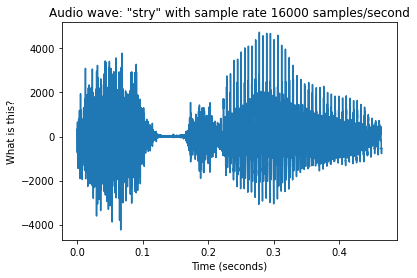

In [277]:
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

Fs, data = scipy.io.wavfile.read('Audiofiles/stry.wav')
title_string = 'Audio wave: "stry" with sample rate '+ str(Fs) + " samples/second"
x_axis = np.linspace(0,len(data)/Fs,len(data)) 
plt.title(title_string)
plt.xlabel("Time (seconds)")
plt.ylabel("What is this?")
plt.plot(x_axis,data)
plt.show()


#### Phoneme characteristics
**Vowels**, such as /iy/, can be characterized by the frequency of the first and second formants. We can characterize the /iy/ vowel by examining the frequency spectrum and finding the frequency corresponding to the peaks of the first and second formants.

**Consonants**, as opposed to vowels, are characterized by significant constriction or obstruction in the oral cavities.


#### The wovel /iy/ and its fundamental frequency

Assuming that we are not supposed to find the fundamental frequency from a frequency spectrum, since the next task is asking about that. 

By plotting the peaks which starts and stops one period and calculating the time difference between them, we find the fundamental frequency to be $F_0 = 178\mathrm{Hz}$
  

Fundamental freq:  177.77777777777777


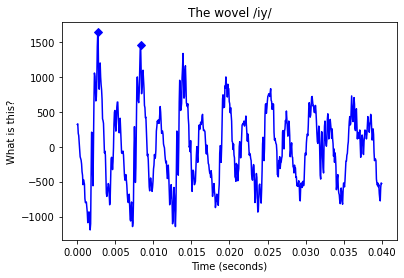

In [278]:
# Assuming that /iy/ is the last 40ms of the signal
desired_time = 40e-3
desired_samples = int(desired_time*Fs)

# We want the last desired_samples of the signal
iy_data = data[len(data)-desired_samples:]
x_axis = np.linspace(0,len(iy_data)/Fs,len(iy_data)) 

def findPeaks(data):
    redPeaks = []
    peaks_red_temp = sig.find_peaks(data)
    for i in range(len(peaks_red_temp)-1):
        for j in peaks_red_temp[i]:
            redPeaks.append(j)
    return redPeaks

# Computing peaks and manually picking the "top" ones for one period
peaks = findPeaks(iy_data)
good_peaks = []
good_peaks.append(peaks[6])
good_peaks.append(peaks[20])
peak_index_distance = good_peaks[1] - good_peaks[0]
fund_freq = Fs/peak_index_distance
print("Fundamental freq: ",fund_freq)

plt.title("The wovel /iy/")
plt.plot(x_axis,iy_data,"-bD",markevery=good_peaks)
plt.xlabel("Time (seconds)")
plt.ylabel("What is this?")
plt.show()



(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the log-spectrum as a function of frequency
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
- Estimate the fundamental frequency $F_0$ using the spectrum, and compare the result to what you got in 1a)
- Roughly estimate the two first formant frequencies.

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

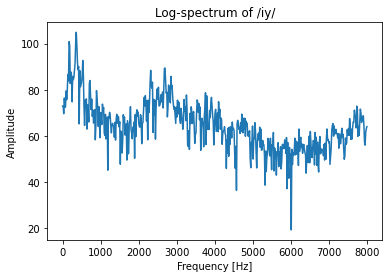

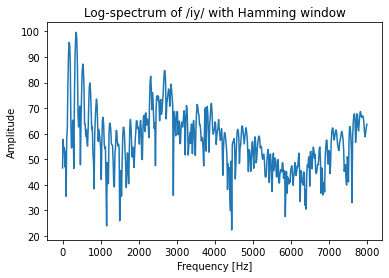

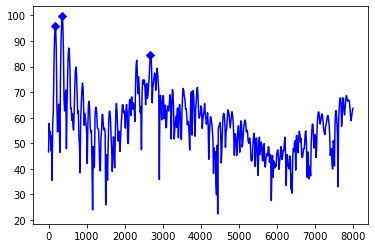

172.21135029354207
360.07827788649706
2677.1037181996085


In [279]:
# Without Hamming window
fft_iy_data = np.fft.fft(iy_data,n=1024)
N = int(len(fft_iy_data)/2)
fft_x_axis = np.linspace(0,(Fs/ 2),N)
plt.title("Log-spectrum of /iy/")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.plot(fft_x_axis,20*np.log10(np.abs(fft_iy_data[:N])))
plt.show()

# With Hamming window
hamming_window = scipy.signal.hamming(len(iy_data))
iy_data_hamming = iy_data * hamming_window
fft_iy_data_hamming = np.fft.fft(iy_data_hamming,n=1024)
plt.title("Log-spectrum of /iy/ with Hamming window")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.plot(fft_x_axis,20*np.log10(np.abs(fft_iy_data_hamming[:N])))
plt.show()

# Finding peaks using Hamming window data
peaks = findPeaks(np.abs(fft_iy_data_hamming[:N]))

good_peaks = []
# The indexes were found manually by plotting all peaks, and finding what peaks corresponded to F0,F1 and F2
for n in (3,5,37):
    good_peaks.append(peaks[n])
plt.plot(fft_x_axis,20*np.log10(np.abs(fft_iy_data_hamming[:N])),"-bD",markevery=good_peaks)
plt.show()

for i in good_peaks:
    print(fft_x_axis[i])


#### The difference between the Hamming window and non-Hamming window

When taking the DFT of a signal, the DFT expects a integer multiple of the period of the signal. When extracting the /iy/ part of the signal, essentially what we are doing is appliying a rectangular window to the window. When doing this, the signal we are "feeding" into the DFT is not an integer multiple of the period. As a result of this spectral leakage will occur. From the DFTs perspective, there is some strange behaviour at the DFTs boundaries which must be caused by other frequencies. As a result, other frequencies than those contained in the original signal will occur and dominate the frequency spectrum. By appliying a Hamming window to the signal we are reducing the spectral leakage (however not completely removing it) which makes the spectrum more smooth.

#### Finding fundamental frequency and the first and second formants

(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the log-spectrum as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?
- Why is it impossible to estimate the fundamental frequency based on the LP model?

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`.

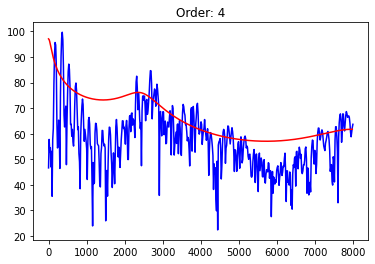

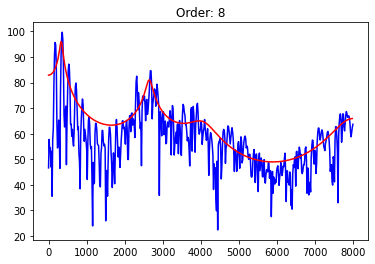

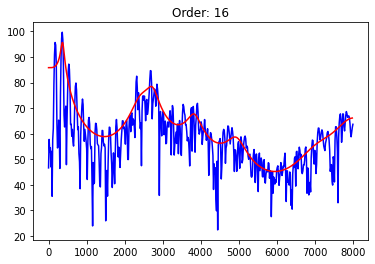

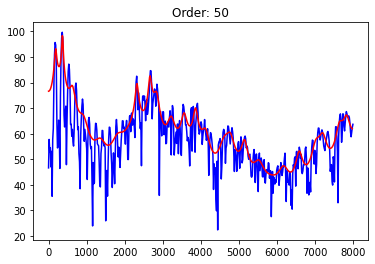

In [280]:
import pysptk

# AR coeffs
for p in (4,8,16,50):
    iy_data_ar_coeff = pysptk.sptk.lpc(iy_data_hamming,order=p)
    #print("The coefficients of the",p,"th  order AR model are: ",iy_data_ar_coeff[1:])
    w,h= sig.freqz(b=iy_data_ar_coeff[0],a=(np.concatenate((np.array([1]),iy_data_ar_coeff[1:]))),fs=Fs)

    # Plotting the log spectrum of the estimated frequency responses
    title_string = "Order: " + str(p)
    plt.title(title_string)
    plt.plot(fft_x_axis,20*np.log10(np.abs(fft_iy_data_hamming[:N])),"b")
    plt.plot(w,20*np.log10(np.abs(h)),"r")
    plt.show()    


(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjutinf the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

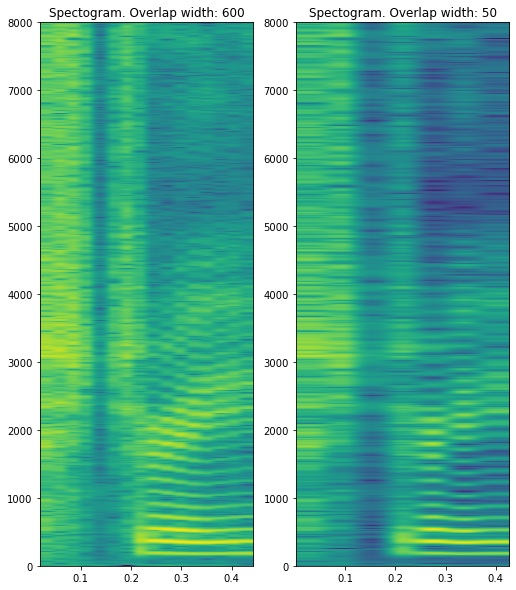

In [281]:
# Assuming we are using ffts of lengths n = 1024 as in prev task

plt.figure(figsize=(3,10))
plt.subplots_adjust(right =2.3)
for overlap in (600,50):
    if overlap == 600:
        plt.subplot(121)
    else:
        plt.subplot(122)
    title_string = "Spectogram. Overlap width: " + str(overlap)
    plt.title(title_string)
    _ = plt.specgram(data,NFFT=1024,Fs=Fs,noverlap=overlap,scale="dB")
plt.show()


### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

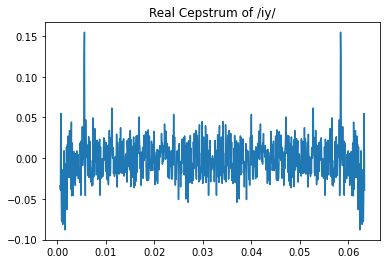

In [282]:

iy_ceptr = np.fft.ifft(np.log(np.abs(fft_iy_data)))
plt.title("Real Cepstrum of /iy/")
x_axis = np.linspace(0,len(iy_ceptr)/Fs,len(iy_ceptr)) 
plt.plot(x_axis[10:len(x_axis)-10],np.real(iy_ceptr[10:len(iy_ceptr)-10]))
plt.show()



(b) Use the cepstrum to compute the fundamental frequency $F_0$. Compare your results with those obtained in problem 1).

When performing ceptral analysis we are sperating the source from the "filter". The source will appear as an impulse train in our ceptstrum. We can see from the cepstrum plot that we have spikes at a certain inteval. These are from the mentioned impulse train. 

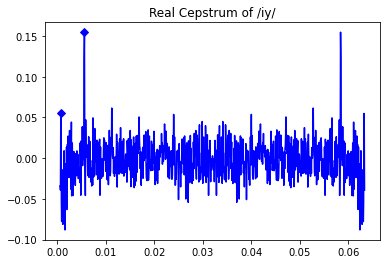

In [283]:
peaks = findPeaks(iy_ceptr[10:len(iy_ceptr)-10])
good_peaks = []
for i in (0,25):
    good_peaks.append(peaks[i])
    
plt.title("Real Cepstrum of /iy/")
x_axis = np.linspace(0,len(iy_ceptr)/Fs,len(iy_ceptr)) 
plt.plot(x_axis[10:len(x_axis)-10],np.real(iy_ceptr[10:len(iy_ceptr)-10]),"-bD",markevery=good_peaks)
plt.show()

(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.

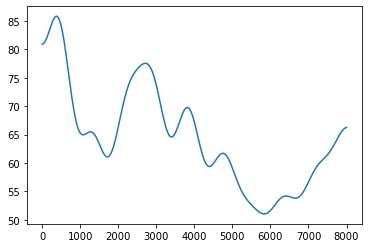

In [284]:
env = iy_ceptr
env[20:len(env)-20] = 0
spec_env = np.abs(np.exp(np.fft.fft(env, n=1024)))
plt.plot(fft_x_axis,20*np.log10(spec_env[:N]))